#Test data trajectory analysis

To generate synthetic sequences we need "paths" that control the movement of the object in the scene. The most obvious source for a generative model for "natural" paths are the test sequences inside the tracking datasets. 

The are many ways to analyze this data. We will try some of these alternatives, starting by a mapping to our synthetic generation model i.e. 5 degrees of freedom (DOF) corresponding to rotation, scaling and translation. The first point analyzed was that as the ground truth bounding boxes are axis-aligned, it is difficult to infer rotation information directly from the box. Therefore, our first visualizations belong to only scaling and translation transformations i.e. 4 DOF.

##Modeling the transformation

Our transformation model is composed of a rotation ($ R( \theta ) $), followed by scaling ($ S(s_{x},s_{y}) $) and finally translation ($ T(t_{x}, t_{y}) $), resulting in a single transform 
$$ T_{full}(\theta, s_{x}, s_{y}, t_{x}, t_{y}) = T(t_{x}, t_{y})*S(s_{x},s_{y})*R( \theta ) $$
$$ T_{full}(\theta, s_{x}, s_{y}, t_{x}, t_{y}) = \begin{bmatrix} 1 & 0 & t_{x} \\ 0 & 1 & t_{y} \\ 0 & 0 & 1 \end{bmatrix} * \begin{bmatrix} s_{x} & 0 & 0 \\ 0 & s_{y} & 0 \\ 0 & 0 & 1 \end{bmatrix} * \begin{bmatrix} cos(\theta) & sin(\theta) & 0 \\ -sin(\theta) & cos(\theta) & 0 \\ 0 & 0 & 1 \end{bmatrix} $$

$$ T_{full}(\theta, s_{x}, s_{y}, t_{x}, t_{y}) = \begin{bmatrix} s_{x}*cos(\theta) & s_{x}*sin(\theta) & t_{x} \\ -s_{y}*sin(\theta) & s_{y}*cos(\theta) & t_{y} \\ 0 & 0 & 1 \end{bmatrix} $$


All this transformations are referenced to the scene coordinates, which has its origin at the top-left corner and increase towards the bottom-right corner.

In order to model the parameters of this transformation, we must first obtain the actual values of the transformation from the ground truth bounding boxes, and then solve the parameters by equating the real transform with the symbolic form stated above.

##Obtaining the transformation matrix

The transformation may be obtained from the points by taking into account that the transformation is the way to project points from one coordinate system to another. 
$$ P^{s}=T_{full}*P^{o} $$
The equation may be stated as "the points in the scene coordinate system are obtained by applying $ T_{full} $ on the points in the object coordinate system"
The unknown here is the transform $ T_{full} $, and the known variables are the points in the scene and object coordinate systems. An affine transform has 6 degrees of freedom (DOF) an therefore 6 independent variables to solve, our transformation has only 5 DOF. The number of DOF is related to the number of points or equations required to solve the transformation matrix. In our case, we are using an overdetermined system, as we are using the 8 coordinates of the 4 bounding box points to find the transformation matrix, which generates 8 equations but only 5 are needed. Nevertheless, the transformation obtained is correct, as the non-colinearity of at least 3 points is satisfyied.

The linear system to solve is then given by
$$ \begin{bmatrix} x_{0}^{s} & ... & x_{n}^{s} \\ y_{0}^{s} & ... & y_{n}^{s} \\ 1 & ... & 1 \end{bmatrix} = T_{full} * \begin{bmatrix} x_{0}^{o} & ... & x_{n}^{o} \\ y_{0}^{o} & ... & y_{n}^{o} \\ 1 & ... & 1 \end{bmatrix}$$
where $ n $ is the number of points available and must satisfy $ n \geq \# DOF $.
The solution is then
$$ T_{full} = \begin{bmatrix} x_{0}^{s} & ... & x_{n}^{s} \\ y_{0}^{s} & ... & y_{n}^{s} \\ 1 & ... & 1 \end{bmatrix} * \begin{bmatrix} x_{0}^{o} & ... & x_{n}^{o} \\ y_{0}^{o} & ... & y_{n}^{o} \\ 1 & ... & 1 \end{bmatrix}^{-1} $$
where the pseudo-inverse may be applied as the matrices used are in general not square.

##Solving for the parameters

Now that we have the transformation matrix, we equate it to the previously defined transformation model

$$ T_{full}(\theta, s_{x}, s_{y}, t_{x}, t_{y}) = \begin{bmatrix} s_{x}*cos(\theta) & s_{x}*sin(\theta) & t_{x} \\ -s_{y}*sin(\theta) & s_{y}*cos(\theta) & t_{y} \\ 0 & 0 & 1 \end{bmatrix} = \begin{bmatrix} x_{0}^{s} & ... & x_{n}^{s} \\ y_{0}^{s} & ... & y_{n}^{s} \\ 1 & ... & 1 \end{bmatrix} * \begin{bmatrix} x_{0}^{o} & ... & x_{n}^{o} \\ y_{0}^{o} & ... & y_{n}^{o} \\ 1 & ... & 1 \end{bmatrix}^{-1} = \begin{bmatrix} t_{1,1} & t_{1,2} & t_{1,3} \\ t_{2,1} & t_{2,2} & t_{2,3} \\ t_{3,1} & t_{3,2} & t_{3,3} \end{bmatrix}$$

where $ t_{3,i} $ need not be solved as they are 0,0, and 1

###Translation parameters

The transformation model and order was selected to obtain a simple and almost decoupled transformation model, where the parameters were easy to solve and analyze. That is evident in the solution of the translation parameters, which correspond directly to the first and second elements of the third column of the real transformation. 
$$ t_{x} = t_{1,3},\space t_{y} = t_{2,3} $$

###Scaling parameters

The scaling and rotation parameters need a more involved solution. An equation omitting the rotation parameter may be obtained by using the trigonometric identity 
$$ coṣ^{2}(\theta)+sin^{2}(\theta)=1$$
which is found by taking the determinant of the matrix over the element $ t_{3,3} $
$$ t_{3,3}*(t_{1,1}*t_{2,2}-t_{1,2}*t_{2,1}) = 1*(s_{x}*cos(\theta)*s_{y}*cos(\theta)-[-s_{y}*sin(\theta)*s_{x}*sin(\theta)]) $$
$$ t_{3,3}*(t_{1,1}*t_{2,2}-t_{1,2}*t_{2,1}) = s_{x}*s_{y}*(coṣ^{2}(\theta)+sin^{2}(\theta)) $$
$$ t_{3,3}*(t_{1,1}*t_{2,2}-t_{1,2}*t_{2,1})= s_{x}*s_{y} $$
The other equation is obtained by a quotient of any of the diagonals of the upper left 2 by 2 matrix
$$ \frac{s_{x}*cos(\theta)}{s_{y}*cos(\theta)} = \frac{s_{x}}{s_{y}} = \frac{t_{1,1}}{t_{2,2}} $$
or
$$ \frac{s_{x}*sin(\theta)}{-s_{y}*sin(\theta)} = \frac{s_{x}}{-s_{y}} = \frac{t_{1,2}}{t_{2,1}} $$
Which equation to use may depend on the numeric stability, as each trigonometric function generates different indeterminations of the quotient. In our case, we are using the following condition to decide
$$ \frac{s_{x}}{s_{y}} = \begin{cases} \frac{t_{1,1}}{t_{2,2}}, & \text{if }| cos(\theta) | \geq | sin(\theta) | \\ -\frac{t_{1,2}}{t_{2,1}}, & \text{otherwise} \end{cases} $$

###Rotation parameter

The rotation parameter is obtained by using the $ atan2 $ function of the diagonal elements
$$ \theta_{PV} = atan2(sy*sin(\theta), sx*cos(\theta)) = atan2(t_{1,2}, t_{1,1})$$
The $ atan2 $ function has a range of $ [-\pi, \pi] $, but we want to model continuous rotations, so we solve for the periodic relation
$$ \theta = \theta_{PV}+n*\pi | n\in\cal{Z} $$
and choose the $ n $ that generates the closest angle to the angle in the previous frame.

In [29]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [30]:
from PIL import Image, ImageDraw
import numpy
import os
import matplotlib
import matplotlib.pyplot
import IPython.display
import animator

In [31]:
#Helper functions

def read_gt(gtPath):
    gtFile = open(gtPath, 'r')
    lines = gtFile.xreadlines()
    #TODO: better replacement of whitespace
    gt = [map(float, line.strip().replace(',', ' ').split()) for line in lines]
    gtFile.close()
    return gt

In [32]:
def draw_polygon(imagePath, polygon):
    image = Image.open(imagePath)
    draw = ImageDraw.ImageDraw(image)
    draw.polygon(polygon)
    return image

In [33]:
def homogeneous_points(coordinates, dims=2):
    values = numpy.reshape(coordinates, (len(coordinates)/2, dims)).T
    points = numpy.vstack([values, numpy.ones((1, values.shape[1]))])
    return points

In [34]:
#NOTE: Depends on transformation order: T*S*R
def transform_params(transform, prevAngle=None):
    x = transform[0,-1]
    y = transform[1,-1]
    originalTheta = numpy.arctan2(transform[0,1],transform[0,0])
    theta = originalTheta
    if prevAngle is not None:
        n = numpy.around((prevAngle - theta)/numpy.pi)
        theta += n*numpy.pi
    ratio1 = numpy.abs(transform[0,0]/transform[1,1])
    ratio2 = -numpy.abs(transform[0,1]/transform[1,0])
    if numpy.abs(numpy.cos(theta)) >= numpy.abs(numpy.sin(theta)):
        ratio = ratio1
    else:
        ratio = ratio2
    product = numpy.abs(transform[0,0])*numpy.abs(transform[1,1])+numpy.abs(transform[0,1])*numpy.abs(transform[1,0])
    sx = numpy.sqrt(product*ratio)
    sy = ratio/sx
    return x,y,sx,sy,theta,originalTheta

In [35]:
gtPath = '/home/fmpaezri/datasets/vot-challenge/sequences/diving/groundtruth.txt'
gt = read_gt(gtPath)

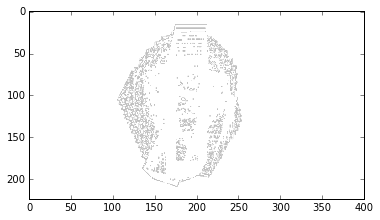

In [36]:
frameSize = Image.open(os.path.join(os.path.dirname(gtPath), '00000001.jpg')).size
image = Image.new('RGBA', frameSize)
canvas = ImageDraw.ImageDraw(image)
for box in gt:
    canvas.polygon(box)
matplotlib.pyplot.imshow(numpy.asarray(image))

In [37]:
output = '/tmp/video.mp4'
sequence = (draw_polygon(os.path.join(os.path.dirname(gtPath), imagePath), gt[i]) for i, imagePath in enumerate(sorted(os.listdir(os.path.dirname(gtPath)))) if imagePath.endswith('.jpg'))
%time animator.frames2video(sequence, 30, output)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

CPU times: user 1.68 s, sys: 17.1 ms, total: 1.7 s
Wall time: 7.08 s


In [38]:
refPoints = homogeneous_points(gt[0])
refPoints = refPoints-numpy.array([[numpy.min(refPoints[0,:]), numpy.min(refPoints[1,:]), 0]]).T
path = numpy.empty((0,6))
averageDiff = 0
previousTheta = None
predictedPointsList = [refPoints[:2,:].T.flatten()]
transformedPointsList = [refPoints[:2,:].T.flatten()]
for i in range(1,len(gt)):
    points = homogeneous_points(gt[i])
    transform = numpy.dot(points, numpy.linalg.pinv(refPoints))
    transformedPoints = numpy.dot(transform, refPoints)
    transformedPointsList.append(transformedPoints[:2,:].T.flatten())
    params = transform_params(transform, prevAngle=previousTheta)
    path = numpy.vstack([path, params])
    tx, ty, sx, sy, theta, originalTheta = params
    previousTheta = theta
    predictedTransform = numpy.array([[sx*numpy.cos(theta), sx*numpy.sin(theta), tx],[-sy*numpy.sin(theta), sy*numpy.cos(theta), ty],[0,0,1]])
    predictedPoints = numpy.dot(predictedTransform, refPoints)
    predictedPointsList.append(predictedPoints[:2,:].T.flatten())
    currentDiff = numpy.linalg.norm(points-predictedPoints)
    #print 'Current difference[{}]: {}\n{}\n{}'.format(i, currentDiff, transform, predictedTransform)
    averageDiff += currentDiff
averageDiff /= len(gt)-1
print 'Average difference: {}'.format(averageDiff)

Average difference: nan


/usr/local/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: RuntimeWarning: invalid value encountered in sqrt


In [39]:
print gt[0]
print refPoints

[174.5, 179.0, 174.5, 17.0, 211.5, 17.0, 211.5, 179.0]
[[   0.    0.   37.   37.]
 [ 162.    0.    0.  162.]
 [   1.    1.    1.    1.]]


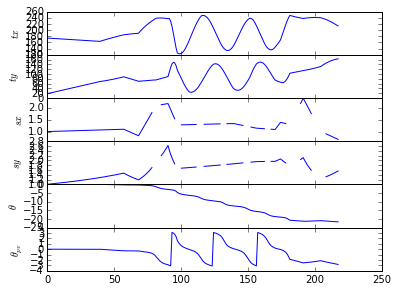

In [40]:
titles = ['$ tx $', '$ ty $', '$ sx $', '$ sy $', '$ \\theta $', '$ \\theta_{pv}$']
matplotlib.pyplot.gcf().subplots_adjust(bottom=0.0, hspace=0.0)
for i in range(path.shape[1]):
    axes = matplotlib.pyplot.subplot(path.shape[1],1,i+1)
    matplotlib.pyplot.plot(path[:,i])
    if i < path.shape[1]-1:
        matplotlib.pyplot.setp( axes.get_xticklabels(), visible=False)
    matplotlib.pyplot.ylabel(titles[i])
#matplotlib.pyplot.tight_layout()

In [41]:
output = '/tmp/video.mp4'
sequence = (draw_polygon(os.path.join(os.path.dirname(gtPath), imagePath), predictedPointsList[i].tolist()) for i, imagePath in enumerate(sorted(os.listdir(os.path.dirname(gtPath)))) if imagePath.endswith('.jpg'))
%time animator.frames2video(sequence, 30, output)
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')
videoTag = '<video controls width="320" height="240"><source src="{0}" type="video/mp4">Unsupported tag</video>'
IPython.display.HTML(videoTag.format(videoSrc))

CPU times: user 1.66 s, sys: 19.8 ms, total: 1.68 s
Wall time: 4.97 s
